### Loading the dataset containing the export data alongside with the nodal attribute available on each country

In [7]:
edges = read.csv('../datasets/wits/edgelist_2011.csv')
nodes = read.csv('../datasets/wits/nodelist_2011.csv')

In [8]:
dim(nodes)

[1] 184   9

### Importing the library required for doing permutation tests

In [9]:
library(coin)
library(sna)
library(ergm)

In [10]:
head(nodes, 3)

,country_iso3,colonizer,inflation_rate,area,gdp_us_dollar,langoff_1,continent,gdp_growth,landlocked
,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<dbl>,<int>
1,AFG,USA,11.804186,652225,17804292964,Persian,Asia,0.4263548,1
2,AGO,PRT,13.482468,1246700,111789686464,Portuguese,Africa,3.4719763,0
3,ALB,NONE,3.429123,28748,12890765324,Albanian,Europe,2.5453218,0


In [11]:
head(edges, 3)

,source,target,weight
,<chr>,<chr>,<dbl>
1,AFG,TKM,0.189
2,ALB,KOR,0.337
3,ALB,MHL,3.309


In [12]:
net = network(edges, directed = TRUE, matrix.type = 'edgelist')

In [13]:
set.vertex.attribute(x = net, attrname = colnames(nodes), value = nodes)

In [14]:
net

 Network attributes:
  vertices = 184 
  directed = TRUE 
  hyper = FALSE 
  loops = FALSE 
  multiple = FALSE 
  bipartite = FALSE 
  total edges= 3774 
    missing edges= 0 
    non-missing edges= 3774 

 Vertex attribute names: 
    area colonizer continent country_iso3 gdp_growth gdp_us_dollar inflation_rate landlocked langoff_1 vertex.names 

 Edge attribute names not shown 

In [16]:
library('tidyverse')

In [17]:
countries_export_import = data.frame(
    country = c(nodes$country_iso3), 
    exports = matrix(0, nrow =184 , ncol = 1),
    imports = matrix(0, nrow =184 , ncol = 1)
)

In [18]:
for (i in 1:length(nodes$country_iso3)) {
    countries_export_import[i, 2:3] = c(
        sum(edges$weight[edges$source == countries_export_import$country[i]]), 
        sum(edges$weight[edges$target == countries_export_import$country[i]])
    )
}

In [19]:
head(countries_export_import, 3)

,country,exports,imports
,<chr>,<dbl>,<dbl>
1,AFG,0.189,1075.7546
2,AGO,0.000,470.5505
3,ALB,132.405,6754.6675


In [20]:
dim(countries_export_import)

[1] 184   3

In [21]:
nodes$exports = countries_export_import$exports
nodes$imports = countries_export_import$imports

In [22]:
head(nodes, 3)

,country_iso3,colonizer,inflation_rate,area,gdp_us_dollar,langoff_1,continent,gdp_growth,landlocked,exports,imports
,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>
1,AFG,USA,11.804186,652225,17804292964,Persian,Asia,0.4263548,1,0.189,1075.7546
2,AGO,PRT,13.482468,1246700,111789686464,Portuguese,Africa,3.4719763,0,0.000,470.5505
3,ALB,NONE,3.429123,28748,12890765324,Albanian,Europe,2.5453218,0,132.405,6754.6675


### Checking the effect of colonization

In [23]:
observed_statistic1 = sum(nodes$exports[nodes$colonizer == 'GBR'])
observed_statistic2 = sum(nodes$imports[nodes$colonizer == 'GBR'])

In [24]:
N = 100000
n = dim(nodes)[1]

In [25]:
permutation_matrix = matrix(0, nrow = n, ncol = N)
for (i in 1:N) {
    permutation_matrix[, i] = sample(nodes$colonizer, size = n, replace = F)
}

In [26]:
permutation_statistics1 = matrix(0, nrow=N, ncol=1)
permutation_statistics2 = matrix(0, nrow=N, ncol=1)
for (i in 1:N) {
    permutation_statistics1[i,] = sum(nodes$exports[permutation_matrix[,i] == 'GBR'])
    permutation_statistics2[i,] = sum(nodes$imports[permutation_matrix[,i] == 'GBR'])
}

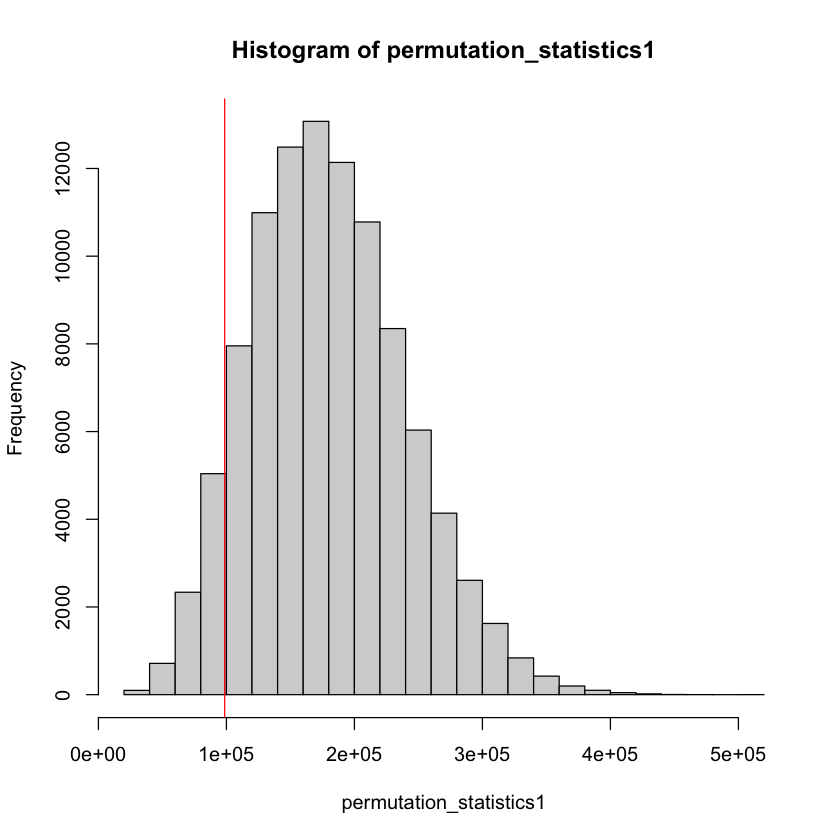

In [27]:
par(bg = 'white')
hist(permutation_statistics1)
abline(v=observed_statistic1, col='red')

In [28]:
mean(permutation_statistics1 < observed_statistic1)

[1] 0.07729

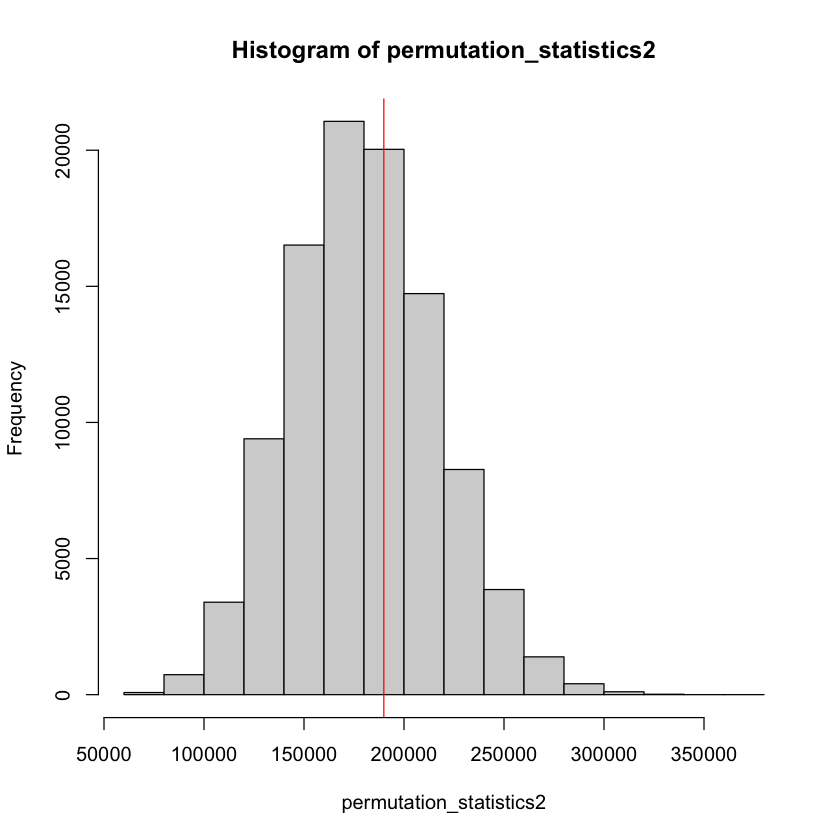

In [29]:
par(bg = 'white')
hist(permutation_statistics2)
abline(v=observed_statistic2, col='red')

In [30]:
mean(permutation_statistics2 < observed_statistic2)

[1] 0.61563

### Examining the effect of distance on the export network using QAPTEST

In [36]:
distance_data = read.csv('../datasets/wits/dist.csv')

In [37]:
head(distance_data, 3)

,source,target,dist
,<chr>,<chr>,<dbl>
1,AFG,AFG,303.7614
2,AFG,AGO,7607.8000
3,AFG,ALB,4342.1170


In [38]:
head(edges, 3)

,source,target,weight
,<chr>,<chr>,<dbl>
1,AFG,TKM,0.189
2,ALB,KOR,0.337
3,ALB,MHL,3.309


In [39]:
n = dim(nodes)[1]
country_names = nodes$country_iso3

In [40]:
adj_matrix = matrix(0, nrow = n, ncol = n)
for (i in 1:n) {
    for (j in i:n) {
        if (sum(edges$source == country_names[i] & edges$target == country_names[j]) > 0) {
            adj_matrix[i, j] = edges$weight[edges$source == country_names[i] & edges$target == country_names[j]]
        }
    }
}
diag(adj_matrix) = 0

In [41]:
dist_matrix = matrix(0, nrow = n, ncol = n)
for (i in 1:n) {
    for (j in i:n) {
        if (sum(distance_data$source == country_names[i] & distance_data$target == country_names[j]) > 0) {
            dist_matrix[i, j] = distance_data$dist[distance_data$source == country_names[i] & distance_data$target == country_names[j]]
        }
    }
}
dist_matrix = dist_matrix + t(dist_matrix)
diag(dist_matrix) = 0

copying the upper triangle in the lower triangle of the network to be able to use the network as a directed one

In [42]:
# wits.netlm = netlm(y = adj_matrix, x = log(dist_matrix), mode = 'digraph', diag = F)

In [43]:
# wits.netlm

In [47]:
execute_qaptest = function(y_matrix, x_matrix, reps=1000) {
    wits.qap = qaptest(dat = list(y_matrix, x_matrix), gcor, g1=1, g2=2, reps = 1000)
    print(wits.qap)
    print(wits.qap$testval)
    par(bg = 'white')
    plot(wits.qap, xlim=c(min(min(wits.qap$dist), wits.qap$testval), max(max(wits.qap$dist), wits.qap$testval)))
    abline(v=wits.qap$testval, col='red')
}


QAP Test Results

Estimated p-values:
	p(f(perm) >= f(d)): 0.01 
	p(f(perm) <= f(d)): 0.99 

[1] 0.0196006


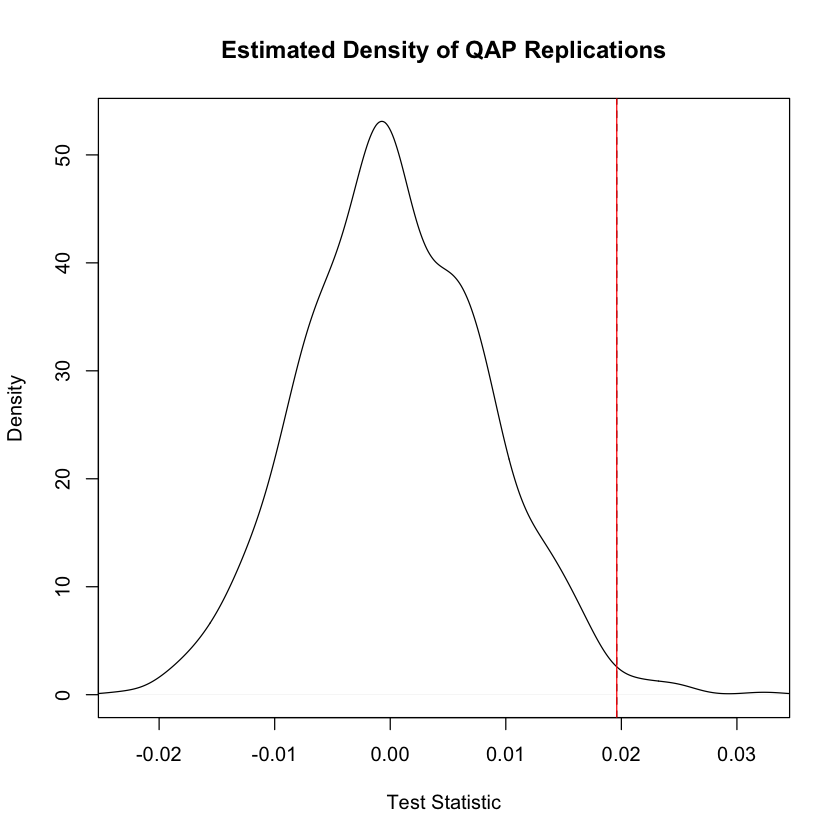

In [48]:
execute_qaptest(adj_matrix, dist_matrix)

### Examining the effect of GDP (both the reporter and the partner)

In [49]:
gdp_matrix = matrix(0, nrow = n, ncol = n)
for (i in 1:n) {
    for (j in i:n) {
        gdp_matrix[i, j] = log(nodes$gdp_us_dollar[i] + nodes$gdp_us_dollar[j])
    }
}
gdp_matrix = gdp_matrix + t(gdp_matrix)
diag(gdp_matrix) = 0


QAP Test Results

Estimated p-values:
	p(f(perm) >= f(d)): 0 
	p(f(perm) <= f(d)): 1 

[1] 0.08002006


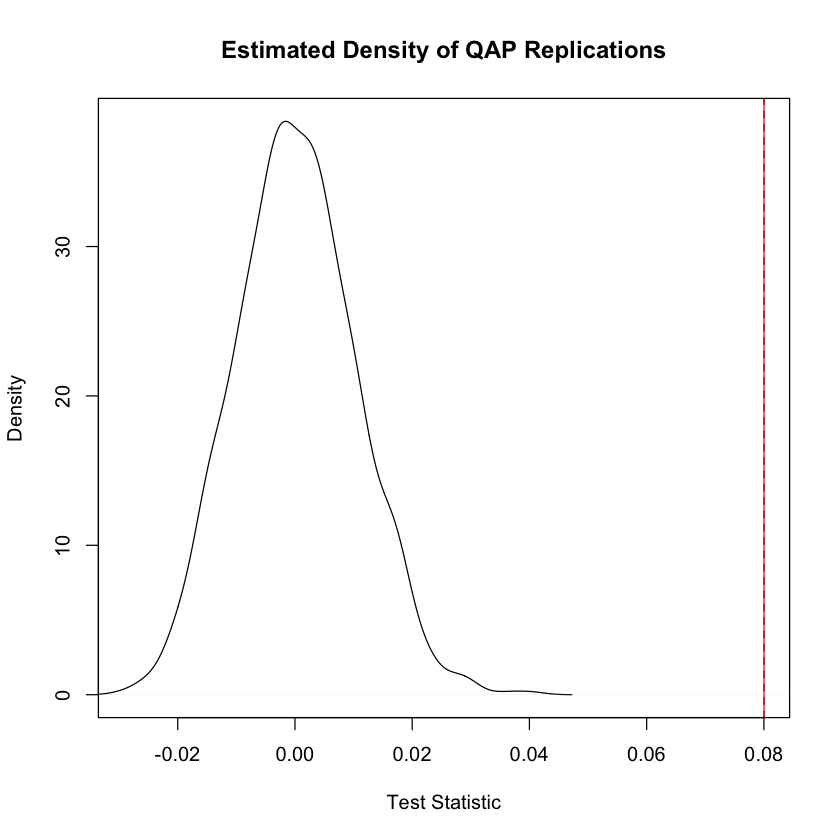

In [50]:
execute_qaptest(adj_matrix, gdp_matrix)

Checking the difference of GDP between the countries

In [51]:
gdp_diff_matrix = matrix(0, ncol = n, nrow = n)
for (i in 1:n) {
    for (j in i:n) {
        gdp_diff_matrix[i, j] = log(abs(nodes$gdp_us_dollar[i] - nodes$gdp_us_dollar[j]))
    }
}
gdp_diff_matrix = gdp_diff_matrix + t(gdp_diff_matrix)
diag(gdp_diff_matrix) = 0


QAP Test Results

Estimated p-values:
	p(f(perm) >= f(d)): 0 
	p(f(perm) <= f(d)): 1 

[1] 0.08151607


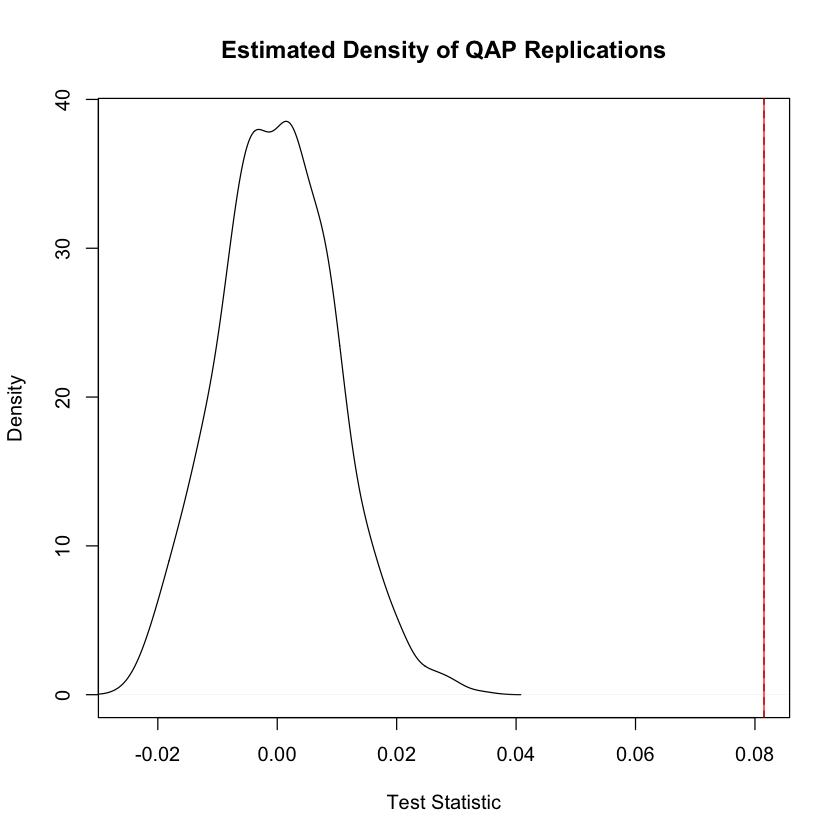

In [52]:
execute_qaptest(adj_matrix, gdp_diff_matrix)

### Examining the effect of homophily on the network of trades

In [70]:
count_homophily = function(edges, nodes, attrs) {
    count = 0
    for (i in 1:dim(edges)[1]) {
        if (attrs[nodes$country_iso3 == edges$source[i]] == attrs[nodes$country_iso3 == edges$target[i]]) {
            count = count + 1
        }
    }
    return(count)
}

In [73]:
execute_homophily_permutation_test = function(edges, nodes, attrs) {
    observed_statistic = count_homophily(edges, nodes, attrs)
    
    N = 1000
    n = dim(nodes)[1]
    
#     generating new samples by permutating the attributes
    permutated_samples = matrix(0, nrow = n, ncol = N)
    for (i in 1:N) {
        permutated_samples[, i] = sample(x = attrs, size = n, replace = F)
    }
    
#     
    permutated_statistics = matrix(0, nrow = N, ncol = 1)
    for (j in 1:N) {
        permutated_statistics[j] = count_homophily(edges, nodes, permutated_samples[, j])
    }
    
    
    par(bg = 'white')
    hist(
        permutated_statistics, 
        xlim=c(min(min(permutated_statistics), observed_statistic), max(max(permutated_statistics), observed_statistic))
    )
    abline(v=observed_statistic, col='red')
    print(mean(permutated_statistics < observed_statistic))
    
}

[1] 0.002


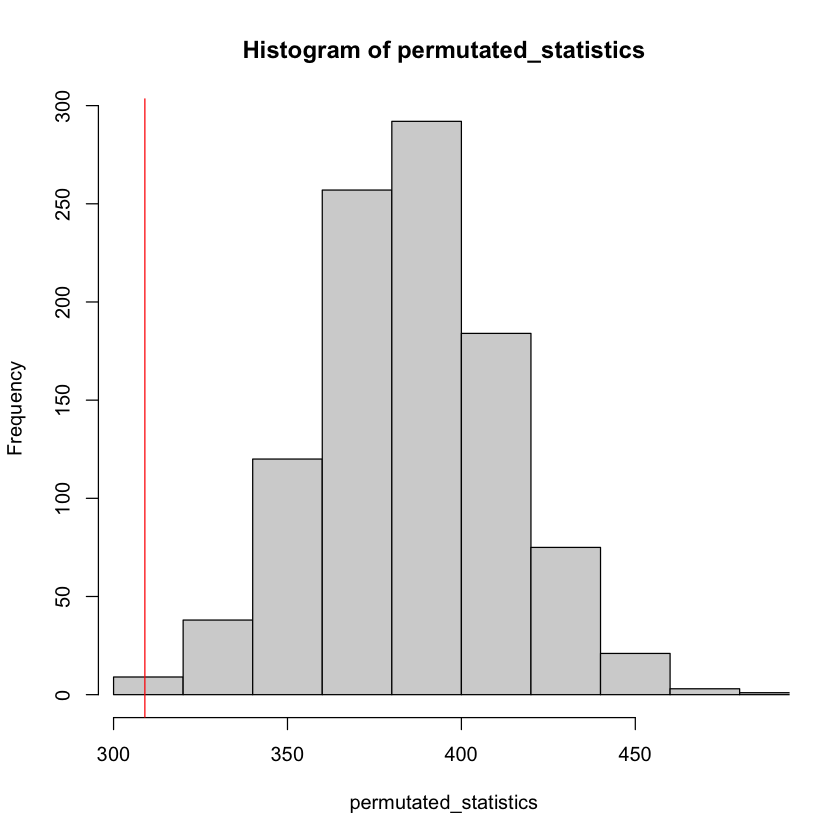

In [74]:
execute_homophily_permutation_test(edges, nodes, nodes$langoff_1)

[1] 0


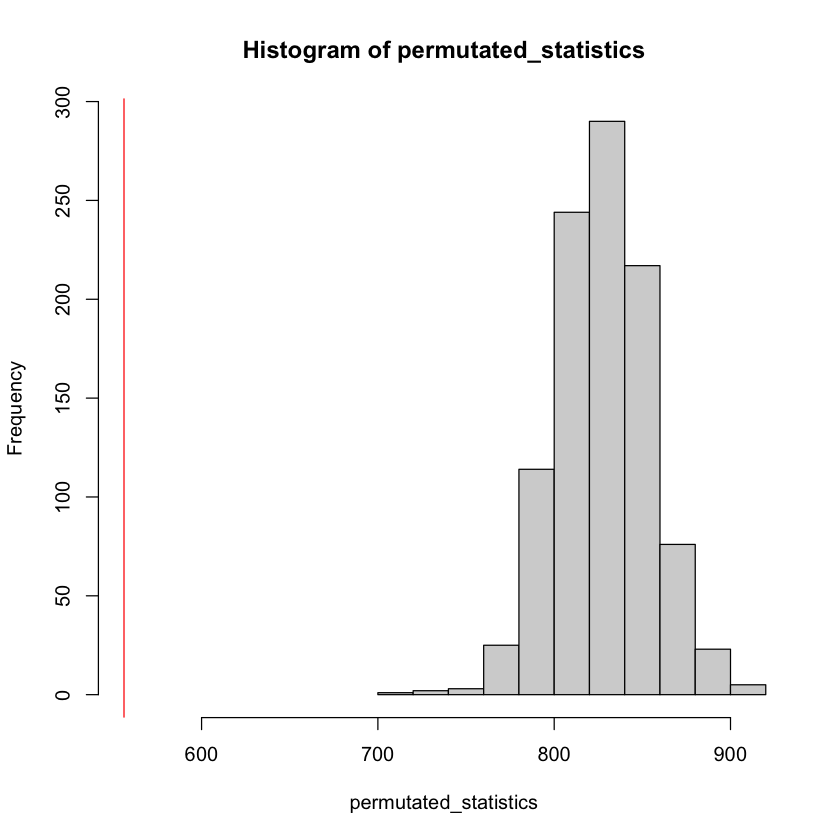

In [75]:
execute_homophily_permutation_test(edges, nodes, nodes$continent)